# Histogram Analysis of Medical Images (Chest and Tumor Mask)

This notebook demonstrates how to perform histogram analysis on a medical image (e.g., a chest scan) and its corresponding tumor mask. We will load the data, visualize it, extract the region of interest (ROI) defined by the mask, and then generate and compare histograms.

## 1. Import Required Libraries
Import necessary libraries such as NumPy for numerical operations, Matplotlib for plotting, and Nibabel for loading NIfTI files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os

# Set some plotting defaults
plt.rcParams['figure.figsize'] = (10, 7)
plt.style.use('ggplot')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Define File Paths and Load Data
Define the file paths for the chest image and the tumor mask. Load the NIfTI files using Nibabel and get the image data as NumPy arrays. Print basic information like shape and data type for both loaded files.

In [2]:
# Define paths to the datasets
# IMPORTANT: Replace these with the actual paths to your NIfTI files.
# For demonstration, we'll use placeholder paths from the example notebook.
# Ensure 'ivim_chest.nii.gz' and 'tumor.nii.gz' are in the specified 'Datasets' subdirectory
# or update paths accordingly.

base_path = '/Users/ayush/Desktop/project-internsip/Datasets/' # Assuming Datasets is in the project-internsip folder
chest_image_path = os.path.join(base_path, 'ivim_chest.nii.gz')
tumor_mask_path = os.path.join(base_path, 'tumor.nii.gz')

def load_nifti_data(file_path, file_description="Data"):
    """
    Load a NIfTI file and return the image data array.
    Prints information about the loaded data.
    Creates dummy data if file not found or loading fails, for notebook to run.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        print(f"Creating dummy {file_description.lower()} for demonstration.")
        if "mask" in file_description.lower():
            # Dummy mask (e.g., a small cube in the center)
            dummy_data = np.zeros((64, 64, 32), dtype=np.int16)
            dummy_data[28:36, 28:36, 14:18] = 1
            return dummy_data
        else:
            # Dummy image data
            dummy_data = np.random.rand(64, 64, 32) * 1000
            dummy_data = dummy_data.astype(np.float32)
            return dummy_data

    try:
        img = nib.load(file_path)
        data = img.get_fdata()
        print(f"\nSuccessfully loaded: {os.path.basename(file_path)} ({file_description})")
        print(f"  Shape: {data.shape}")
        print(f"  Data type: {data.dtype}")
        print(f"  Min value: {data.min():.2f}, Max value: {data.max():.2f}")
        if len(data.shape) == 4: # If 4D data, mention it
             print(f"  This is 4D data. Analysis will typically focus on one volume (e.g., data[..., 0]).")
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        print(f"Creating dummy {file_description.lower()} due to loading error.")
        if "mask" in file_description.lower():
            dummy_data = np.zeros((64, 64, 32), dtype=np.int16)
            dummy_data[28:36, 28:36, 14:18] = 1
            return dummy_data
        else:
            dummy_data = np.random.rand(64, 64, 32) * 1000
            dummy_data = dummy_data.astype(np.float32)
            return dummy_data

# Load the chest image
print("--- Loading Chest Image ---")
chest_image_data = load_nifti_data(chest_image_path, "Chest Image")
# If 4D, select the first volume for simplicity in this notebook
if chest_image_data is not None and len(chest_image_data.shape) == 4:
    print("Selecting first volume (index 0) from 4D chest image data for this analysis.")
    chest_image_data = chest_image_data[..., 0] # Using first volume
    print(f"  New shape for analysis: {chest_image_data.shape}")


# Load the tumor mask
print("\n--- Loading Tumor Mask ---")
tumor_mask_data = load_nifti_data(tumor_mask_path, "Tumor Mask")
# If 4D mask (unlikely but possible), select first volume
if tumor_mask_data is not None and len(tumor_mask_data.shape) == 4:
    print("Selecting first volume (index 0) from 4D tumor mask data for this analysis.")
    tumor_mask_data = tumor_mask_data[..., 0] # Using first volume
    print(f"  New shape for analysis: {tumor_mask_data.shape}")


# Verify shapes if both loaded successfully
if chest_image_data is not None and tumor_mask_data is not None:
    # We only compare the first 3 dimensions if chest_image_data was originally 4D
    if chest_image_data.shape[:3] != tumor_mask_data.shape[:3]:
        print(f"\nWarning: Chest image spatial shape {chest_image_data.shape[:3]} and tumor mask spatial shape {tumor_mask_data.shape[:3]} do not match!")
        print("Ensure they correspond to the same anatomical space for meaningful ROI extraction.")
    else:
        print("\nChest image and tumor mask spatial shapes match.")
else:
    print("\nCould not load one or both datasets properly. Subsequent cells might produce errors or use dummy data.")

--- Loading Chest Image ---

Successfully loaded: ivim_chest.nii.gz (Chest Image)
  Shape: (224, 224, 67, 9)
  Data type: float64
  Min value: 0.00, Max value: 3827.76
  This is 4D data. Analysis will typically focus on one volume (e.g., data[..., 0]).
Selecting first volume (index 0) from 4D chest image data for this analysis.
  New shape for analysis: (224, 224, 67)

--- Loading Tumor Mask ---

Successfully loaded: tumor.nii.gz (Tumor Mask)
  Shape: (192, 192, 64)
  Data type: float64
  Min value: 0.00, Max value: 1.00

Ensure they correspond to the same anatomical space for meaningful ROI extraction.


## 3. Visualize Loaded Images and Masks
Display a representative slice from the chest image and the tumor mask to visually inspect the loaded data. This helps confirm correct loading and orientation.


--- Visualizing Chest Image Slice ---


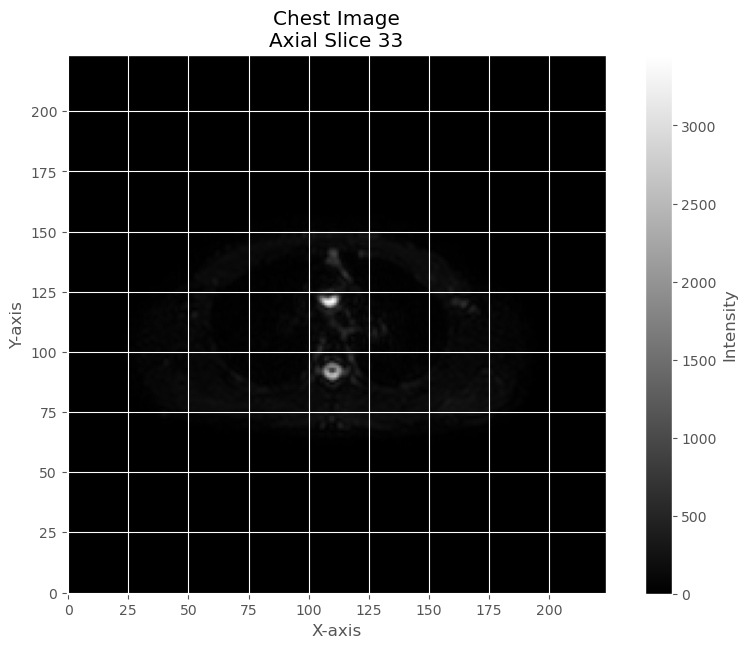


--- Visualizing Tumor Mask Slice ---


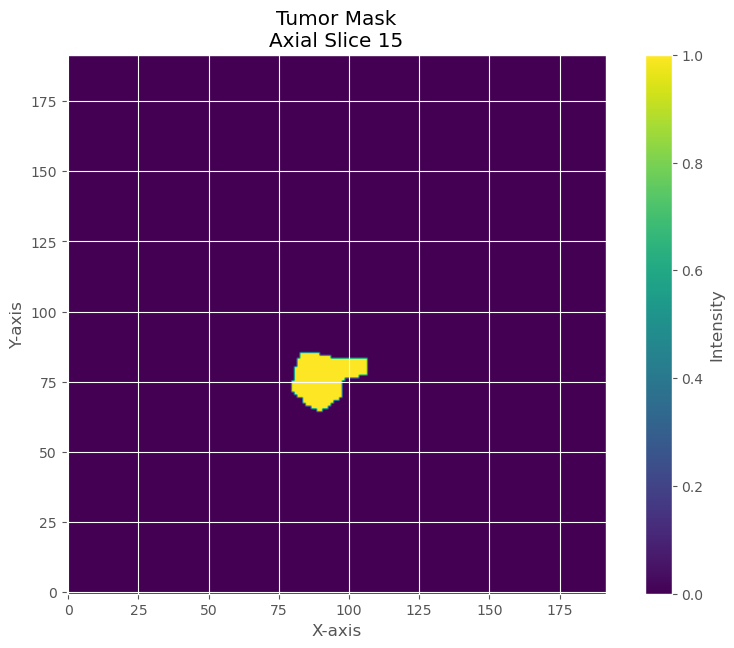

In [3]:
def display_slice(data, slice_index=None, axis=2, title="Image Slice", cmap='gray'):
    """
    Display a slice from a 3D NIfTI data array.
    """
    if data is None:
        print(f"Cannot display slice: Data for '{title}' is None.")
        return

    if len(data.shape) != 3:
        print(f"Error: display_slice expects 3D data, but got shape {data.shape} for '{title}'.")
        # If it's 2D, try to display it directly
        if len(data.shape) == 2:
            plt.imshow(data.T, cmap=cmap, origin='lower')
            plt.title(f"{title} (2D Data)")
            plt.colorbar(label='Intensity')
            plt.axis('on') # Show axes for 2D
            plt.show()
        return

    # Select the middle slice if not specified
    if slice_index is None:
        slice_index = data.shape[axis] // 2
    
    # Ensure slice_index is within bounds
    if not (0 <= slice_index < data.shape[axis]):
        print(f"Error: slice_index {slice_index} is out of bounds for axis {axis} with shape {data.shape[axis]}. Using middle slice.")
        slice_index = data.shape[axis] // 2


    # Extract the slice
    if axis == 0: # Sagittal
        slice_data = data[slice_index, :, :]
        orientation = "Sagittal"
    elif axis == 1: # Coronal
        slice_data = data[:, slice_index, :]
        orientation = "Coronal"
    else:  # axis == 2 (Axial)
        slice_data = data[:, :, slice_index]
        orientation = "Axial"

    plt.imshow(slice_data.T, cmap=cmap, origin='lower') # Use .T and origin='lower' for typical medical image display
    plt.title(f"{title}\n{orientation} Slice {slice_index}")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.colorbar(label='Intensity')
    plt.show()

# Visualize chest image
if chest_image_data is not None:
    print("\n--- Visualizing Chest Image Slice ---")
    middle_slice_idx_img = chest_image_data.shape[2] // 2 if len(chest_image_data.shape) == 3 else None
    display_slice(chest_image_data, slice_index=middle_slice_idx_img, axis=2, title="Chest Image")
else:
    print("Chest image data not loaded, skipping visualization.")

# Visualize tumor mask
if tumor_mask_data is not None:
    print("\n--- Visualizing Tumor Mask Slice ---")
    best_mask_slice_idx = None
    if len(tumor_mask_data.shape) == 3:
        # Try to find a slice with non-zero mask voxels
        sums_per_slice = np.sum(tumor_mask_data, axis=(0,1)) # Sum over x and y for each z slice
        if np.any(sums_per_slice > 0):
            best_mask_slice_idx = np.argmax(sums_per_slice)
        else: # If all slices are zero, use middle
            best_mask_slice_idx = tumor_mask_data.shape[2] // 2
    
    display_slice(tumor_mask_data, slice_index=best_mask_slice_idx, axis=2, title="Tumor Mask", cmap='viridis')
else:
    print("Tumor mask data not loaded, skipping visualization.")

## 4. Apply Mask to Extract Region of Interest (ROI)
Use the tumor mask to extract the corresponding region of interest (ROI) from the chest image. This typically involves ensuring the mask is binary and then performing an element-wise multiplication of the chest image data with the mask. Display a slice of the masked chest image.

In [4]:
def apply_mask_to_image(image_data, mask_data):
    """
    Applies a binary mask to image data.
    Assumes image_data and mask_data have the same 3D spatial shape.
    """
    if image_data is None or mask_data is None:
        print("Cannot apply mask: Image or mask data is None.")
        return None
        
    if image_data.shape[:3] != mask_data.shape[:3]: # Compare spatial dimensions
        print(f"Error: Image spatial shape {image_data.shape[:3]} and mask spatial shape {mask_data.shape[:3]} must match to apply mask.")
        return None

    # Ensure mask is binary (0s and 1s)
    # If mask has values other than 0 and 1, treat any non-zero as 1.
    binary_mask = (mask_data > 0).astype(image_data.dtype) 

    masked_image = image_data * binary_mask
    print(f"\nMask applied.")
    print(f"  Original image non-zero voxels (approx): {np.count_nonzero(image_data > 1e-5)}") # Use a small threshold for float data
    print(f"  Mask non-zero voxels: {np.count_nonzero(binary_mask)}")
    print(f"  Masked image non-zero voxels (ROI): {np.count_nonzero(masked_image > 1e-5)}")
    return masked_image

# Apply the mask
print("\n--- Applying Mask to Chest Image ---")
masked_chest_image_data = None
if chest_image_data is not None and tumor_mask_data is not None:
    masked_chest_image_data = apply_mask_to_image(chest_image_data, tumor_mask_data)

    # Visualize the masked chest image
    if masked_chest_image_data is not None:
        print("\n--- Visualizing Masked Chest Image Slice (ROI) ---")
        # Use the same slice index as the tumor mask visualization for comparison, if available
        slice_to_show_roi = None
        if 'best_mask_slice_idx' in locals() and best_mask_slice_idx is not None:
             slice_to_show_roi = best_mask_slice_idx
        elif len(masked_chest_image_data.shape) == 3:
             slice_to_show_roi = masked_chest_image_data.shape[2] // 2
        
        display_slice(masked_chest_image_data, slice_index=slice_to_show_roi, axis=2, title="Masked Chest Image (ROI)")
    else:
        print("Masked chest image data not generated, skipping visualization.")
else:
    print("Cannot apply mask as chest image or tumor mask data is not loaded.")


--- Applying Mask to Chest Image ---
Error: Image spatial shape (224, 224, 67) and mask spatial shape (192, 192, 64) must match to apply mask.
Masked chest image data not generated, skipping visualization.


## 5. Generate Histogram for the Full Chest Image
Calculate and plot the histogram of intensity values for the entire chest image. This shows the overall distribution of pixel/voxel intensities. Consider excluding zero-intensity background voxels for a more informative histogram of the tissue.


--- Histogram for Full Chest Image ---
Statistics for 'Histogram of Full Chest Image (Non-Background Voxels)':
  Number of voxels: 1,129,181
  Min: 1.26, Max: 3827.76
  Mean: 68.46, Median: 26.56, Std Dev: 129.90


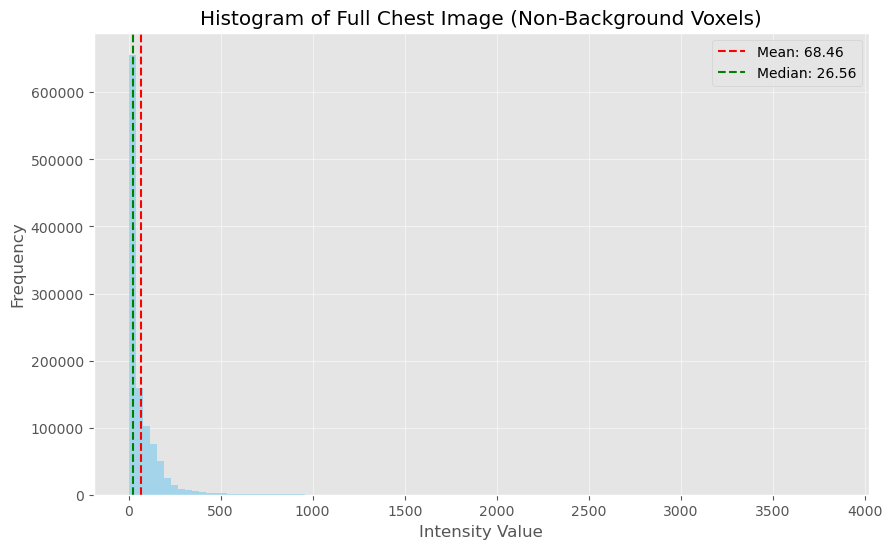

In [5]:
def plot_histogram(data_values, title, bins=100, color='blue', log_scale=False):
    """
    Plots a histogram for the given 1D data values.
    """
    if data_values is None or len(data_values) == 0:
        print(f"No data to plot for histogram '{title}'.")
        return

    plt.figure(figsize=(10, 6))
    counts, bin_edges, _ = plt.hist(data_values, bins=bins, color=color, alpha=0.7, log=log_scale)
    plt.title(title)
    plt.xlabel("Intensity Value")
    plt.ylabel("Frequency" + (" (Log Scale)" if log_scale else ""))
    plt.grid(True, alpha=0.5)
    
    mean_val = np.mean(data_values)
    median_val = np.median(data_values)
    std_val = np.std(data_values)
    
    # Add vertical lines for mean and median
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_val:.2f}')
    plt.legend()
    
    print(f"Statistics for '{title}':")
    print(f"  Number of voxels: {len(data_values):,}")
    print(f"  Min: {np.min(data_values):.2f}, Max: {np.max(data_values):.2f}")
    print(f"  Mean: {mean_val:.2f}, Median: {median_val:.2f}, Std Dev: {std_val:.2f}")
    plt.show()

# Generate histogram for the full chest image
print("\n--- Histogram for Full Chest Image ---")
if chest_image_data is not None:
    # Flatten the data and exclude zero/very-low intensity background voxels for a more informative histogram of tissue
    full_image_values_for_hist = chest_image_data[chest_image_data > 1e-5].flatten() # Threshold can be adjusted
    if len(full_image_values_for_hist) > 0:
        plot_histogram(full_image_values_for_hist, "Histogram of Full Chest Image (Non-Background Voxels)", bins=100, color='skyblue')
    else:
        print("No non-background voxels found in chest image data for histogram.")
else:
    print("Chest image data not loaded, skipping histogram.")

## 6. Generate Histogram for the Tumor Mask
Calculate and plot the histogram of values for the tumor mask. For a binary mask, this will typically show counts for 0 (background) and 1 (mask region), confirming its nature.


--- Histogram for Tumor Mask ---
Statistics for 'Histogram of Tumor Mask Values':
  Number of voxels: 2,359,296
  Min: 0.00, Max: 1.00
  Mean: 0.00, Median: 0.00, Std Dev: 0.03


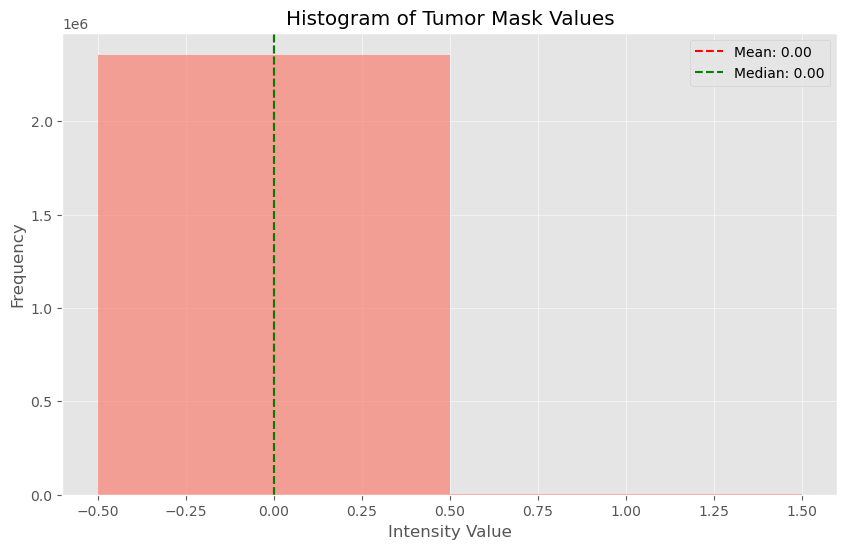

Unique values and counts in tumor mask:
  Value: 0.0, Count: 2,357,126
  Value: 1.0, Count: 2,170


In [6]:
# Generate histogram for the tumor mask
print("\n--- Histogram for Tumor Mask ---")
if tumor_mask_data is not None:
    mask_values_for_hist = tumor_mask_data.flatten()
    
    # For masks, we usually want to see all discrete values, including zeros
    # Determine unique values for bins if they are few, otherwise use a small number of bins
    unique_mask_vals = np.unique(mask_values_for_hist)
    if len(unique_mask_vals) < 15: # If few unique values, use them for bin edges
        # Create bins centered around unique values
        bin_edges = np.concatenate((unique_mask_vals - 0.5, [unique_mask_vals[-1] + 0.5]))
        num_bins = bin_edges
    else:
        num_bins = 15 # Default number of bins if many unique values (e.g. probability map)

    plot_histogram(mask_values_for_hist, "Histogram of Tumor Mask Values", bins=num_bins, color='salmon')
    
    # Print unique values and their counts for clarity
    unique_vals, counts = np.unique(mask_values_for_hist, return_counts=True)
    print("Unique values and counts in tumor mask:")
    for val, count in zip(unique_vals, counts):
        print(f"  Value: {val}, Count: {count:,}")
else:
    print("Tumor mask data not loaded, skipping histogram.")

## 7. Generate Histogram for the Extracted ROI
Calculate and plot the histogram of intensity values specifically for the extracted tumor ROI from the chest image. This focuses the analysis on the intensity distribution within the tumor.

In [7]:
# Generate histogram for the extracted ROI
print("\n--- Histogram for Extracted ROI (from Masked Chest Image) ---")
roi_intensity_values = None
if masked_chest_image_data is not None:
    # The masked_chest_image_data contains zeros outside the ROI.
    # We only want to plot the histogram of the non-zero values, which are the ROI values.
    # A small threshold might be needed if the original image had very small positive values outside the true ROI
    # that were not perfectly zeroed by multiplication if mask was not perfectly binary.
    roi_intensity_values = masked_chest_image_data[tumor_mask_data > 0].flatten() # More robust way using original mask
    # roi_intensity_values = masked_chest_image_data[masked_chest_image_data > 1e-5].flatten() # Alternative if mask is perfectly applied

    if len(roi_intensity_values) > 0:
        plot_histogram(roi_intensity_values, "Histogram of Extracted ROI Intensities", bins=50, color='lightgreen')
    else:
        print("No intensity values found in the extracted ROI (it might be empty or all zero).")
elif chest_image_data is not None and tumor_mask_data is not None:
    # Fallback if masked_chest_image_data was not created but original components exist
    print("Masked image not available, extracting ROI values directly from chest image and tumor mask.")
    roi_intensity_values = chest_image_data[tumor_mask_data > 0].flatten()
    if len(roi_intensity_values) > 0:
        plot_histogram(roi_intensity_values, "Histogram of Extracted ROI Intensities (Direct)", bins=50, color='lightgreen')
    else:
        print("No intensity values found in the ROI (it might be empty or all zero).")
else:
    print("Masked chest image data (ROI) not available, and original data missing. Skipping histogram.")


--- Histogram for Extracted ROI (from Masked Chest Image) ---
Masked image not available, extracting ROI values directly from chest image and tumor mask.


IndexError: boolean index did not match indexed array along dimension 0; dimension is 224 but corresponding boolean dimension is 192

## 8. Compare Histograms of Chest Image and ROI
Overlay or plot side-by-side the histograms of the full chest image (or relevant non-masked part) and the extracted ROI to visually compare their intensity distributions. Use appropriate labeling and legends.

In [8]:
print("\n--- Comparing Histograms: Full Chest Image (Non-Background) vs. ROI ---")

# Prepare data for comparison
full_image_comp_values = None
if chest_image_data is not None:
    full_image_comp_values = chest_image_data[chest_image_data > 1e-5].flatten()

# roi_intensity_values should be available from the previous cell
# If not, try to re-extract:
if 'roi_intensity_values' not in locals() or roi_intensity_values is None or len(roi_intensity_values) == 0:
    if chest_image_data is not None and tumor_mask_data is not None:
        roi_intensity_values = chest_image_data[tumor_mask_data > 0].flatten()

if full_image_comp_values is not None and len(full_image_comp_values) > 0 and \
   roi_intensity_values is not None and len(roi_intensity_values) > 0:
    
    plt.figure(figsize=(12, 7))

    # Determine a common range for bins for better comparison, or let hist decide
    # combined_min = min(full_image_comp_values.min(), roi_intensity_values.min())
    # combined_max = max(full_image_comp_values.max(), roi_intensity_values.max())
    # bins_shared = np.linspace(combined_min, combined_max, 75)

    # Plot histogram for full image (non-zero) - Normalized (density=True)
    plt.hist(full_image_comp_values, bins=75, alpha=0.6, label='Full Chest Image (Non-Background)', color='skyblue', density=True)

    # Plot histogram for ROI - Normalized (density=True)
    plt.hist(roi_intensity_values, bins=50, alpha=0.8, label='Extracted ROI', color='lightgreen', density=True)

    plt.title("Comparison of Intensity Histograms (Normalized)")
    plt.xlabel("Intensity Value")
    plt.ylabel("Density (Normalized Frequency)")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()
else:
    print("Not enough data to compare histograms (full image or ROI might be empty after filtering).")

print("\n\n--- Notebook execution complete. ---")


--- Comparing Histograms: Full Chest Image (Non-Background) vs. ROI ---


IndexError: boolean index did not match indexed array along dimension 0; dimension is 224 but corresponding boolean dimension is 192